In [1]:
# ────────────────────────────────────────────────────────────────────────────
#   0. Setup & imports
# ────────────────────────────────────────────────────────────────────────────
import ee, geemap
import numpy as np
import geopandas as gpd
from shapely.geometry import shape, mapping, Polygon
from pyproj import CRS
from stl import mesh                           # numpy-stl
from pathlib import Path

import k3d
import ipywidgets as widgets
import matplotlib.pyplot as plt
import contextily as ctx

ee.Initialize()        # after you have authenticated once

# Handy helper ──────────────────────────────────────────────────────────────
def utm_for_geom(geom: Polygon) -> CRS:
    """Return a UTM CRS centred on *geom* (assumes WGS-84 input)."""
    lon = geom.centroid.x
    zone = int((lon + 180) // 6) + 1
    south = geom.centroid.y < 0
    return CRS.from_epsg(32700 + zone if south else 32600 + zone)


In [2]:
# ────────────────────────────────────────────────────────────────────────────
#   1. User inputs
# ────────────────────────────────────────────────────────────────────────────
# Example AOI – roughly 4×4 mi ridge in Angeles NF near Mt Josephine
sample_geojson = {
    "type": "Polygon",
    "coordinates": [[
        [-118.0937, 34.3530],
        [-118.0583, 34.3620],
        [-118.0462, 34.3392],
        [-118.0830, 34.3302],
        [-118.0937, 34.3530]
    ]]
}

VERTICAL_EXAG = 3.0          # exaggerate z 3×
MM_PER_METER  = 0.05         # print at 1 : 20 000  →  0.05 mm per real-m
BASE_THICK_MM = 2.0          # keep at least 2 mm below lowest terrain
DEM_SCALE_M   = 30           # input DEM cell size (m)  (SRTM is 30 m)

aoi_wgs  = shape(sample_geojson)
proj_crs = utm_for_geom(aoi_wgs)


In [7]:
# ───── Cell 2 – simplest working version ────────────────────────────────
scale = DEM_SCALE_M                 # 30 m

arr = geemap.ee_to_numpy(
    dem_clip,                       # already clipped to your AOI
    region=aoi_fc.geometry(),       # still WGS-84
    scale=scale                     # <- **only** the args that API allows
)

elev = np.flipud(arr[:, :, 0])      # remove band dim, flip N-to-S
print(elev.shape, elev.min(), elev.max())


(118, 146) 1144 1922


In [9]:
# ────────────────────────────────────────────────────────────────────────
# 3. Build a clean, vector-based mesh (no pixelated edges!)
# ────────────────────────────────────────────────────────────────────────
from shapely.ops     import triangulate
from shapely.affinity import scale as shp_scale
from stl import mesh
from pathlib import Path

# 3-A  XY grid of DEM nodes (projected metres)
h, w = elev.shape
xv = np.linspace(0, (w - 1) * scale, w)
yv = np.linspace(0, (h - 1) * scale, h)
X, Y = np.meshgrid(xv, yv)

# 3-B  Convert to print units and exaggerate Z
X_mm = X * MM_PER_METER
Y_mm = Y * MM_PER_METER
Z_mm = (elev - elev.min()) * VERTICAL_EXAG * MM_PER_METER
z_base = -BASE_THICK_MM

# ───────────────────────────────── TOP SURFACE ──────────────────────────
faces_top = []
for i in range(h - 1):
    for j in range(w - 1):
        idx00 = i      * w + j        # four node indices of the grid cell
        idx10 = (i + 1) * w + j
        idx01 = i      * w + j + 1
        idx11 = (i + 1) * w + j + 1
        # two triangles per quad:  (00-10-01) and (10-11-01)
        faces_top.append([idx00, idx10, idx01])
        faces_top.append([idx10, idx11, idx01])
faces_top = np.asarray(faces_top, dtype=np.int32)

tri_top_xyz = np.c_[
    X_mm.ravel()[faces_top],
    Y_mm.ravel()[faces_top],
    Z_mm.ravel()[faces_top],
].reshape(-1, 9)

# ──────────────────────────────── SIDE WALLS ────────────────────────────
aoi_m  = gpd.GeoSeries([aoi_wgs], crs=4326).to_crs(proj_crs).iloc[0]
aoi_mm = shp_scale(aoi_m, xfact=MM_PER_METER, yfact=MM_PER_METER, origin=(0, 0))

coords = np.asarray(aoi_mm.exterior.coords)
walls = []
for p0, p1 in zip(coords[:-1], coords[1:]):       # loop over edges
    # build a quad (p0-p1 vertical) → split into two triangles
    walls.append([[p0[0], p0[1], Z_mm.min()],
                  [p1[0], p1[1], Z_mm.min()],
                  [p1[0], p1[1], z_base]])
    walls.append([[p0[0], p0[1], Z_mm.min()],
                  [p1[0], p1[1], z_base],
                  [p0[0], p0[1], z_base]])
walls = np.asarray(walls, dtype=np.float32).reshape(-1, 9)

# ───────────────────────────────── BOTTOM ───────────────────────────────
bottom = np.asarray(
    [[[x, y, z_base] for x, y in tri.exterior.coords[:3]]
     for tri in triangulate(aoi_mm)],
    dtype=np.float32,
).reshape(-1, 9)

# ─────────────────────────────── CONCAT & STL ───────────────────────────
triangles = np.vstack([tri_top_xyz, walls, bottom])

terrain_mesh = mesh.Mesh(np.zeros(len(triangles), dtype=mesh.Mesh.dtype))
terrain_mesh.vectors = triangles.reshape(-1, 3, 3)

stl_path = Path('terrain_model.stl')
terrain_mesh.save(stl_path)
print("✓ STL written →", stl_path.resolve())


✓ STL written → /TouchTerrain/standalone/terrain_model.stl


AttributeError: Stamen

<Figure size 500x500 with 0 Axes>

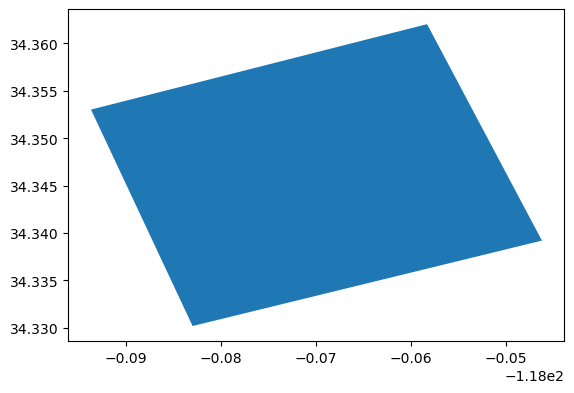

In [10]:
# ────────────────────────────────────────────────────────────────────────────
#   4. Quick visual sanity check in 3-D  (K3D)
# ────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(5,5))
gpd.GeoSeries([aoi_wgs]).plot()
ctx.add_basemap(plt.gca(), source=ctx.providers.Stamen.Terrain)
plt.title("AOI footprint"); plt.axis('off');

plot = k3d.plot(grid_visible=False, axes_helper=0)
plot += k3d.mesh(terrain_mesh.vectors.reshape(-1,3),
                 color=0x99ccff, flat_shading=False)
plot.display()
